In [1]:
#import libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [2]:
datatrend=pd.read_csv('../data/cleaned_data.csv')

In [3]:
datatrend.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,Total_price,InvoiceYear,InvoiceMonth
0,536365,2010-12-01,17850.0,SC1734,Electronics,65,10.23,Egypt,664.95,2010,2010-12
1,536365,2010-12-01,17850.0,SC2088,Furniture,95,19.61,Mali,1862.95,2010,2010-12
2,536365,2010-12-01,17850.0,SC3463,Books,78,61.49,Mali,4796.22,2010,2010-12
3,536365,2010-12-01,17850.0,SC6228,Toys,15,24.73,South Africa,370.95,2010,2010-12
4,536365,2010-12-01,17850.0,SC2149,Toys,50,38.83,Rwanda,1941.50,2010,2010-12


In [4]:
rfm = pd.read_csv('../data/rfm_data.csv')
rfm.head()

,Recency,Frequency,Monetary,T
0,341,2,5342.40,341
1,7,7,431501.00,372
2,98,4,82378.47,372
3,37,1,176075.12,37
4,310,1,48173.37,310


In [20]:
from lifetimes.utils import summary_data_from_transaction_data

rfm = summary_data_from_transaction_data(
    datatrend,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='Total_price',  # Only if you want monetary value
    observation_period_end=datatrend['InvoiceDate'].max()
)

rfm.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,334.0,0.000000
12347.0,6.0,365.0,365.0,59683.226667
12348.0,3.0,274.0,365.0,12374.866667
12349.0,0.0,0.0,30.0,0.000000
12350.0,0.0,0.0,303.0,0.000000


In [21]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])


<lifetimes.BetaGeoFitter: fitted with 4372 subjects, a: 0.00, alpha: 172.25, b: 0.00, r: 1.52>

In [6]:
!pip install lifetimes

In [7]:
from lifetimes import BetaGeoFitter

# Initialize the model
bgf = BetaGeoFitter()

# Fit the model
bgf.fit(frequency=rfm['Frequency'], recency=rfm['Recency'], T=rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 4372 subjects, a: 9.13, alpha: 1.09, b: 63.33, r: 0.34>

In [8]:
print("BG/NBD Model Parameters:")
print(f"r: {bgf.params_['r']:.4f}")
print(f"alpha: {bgf.params_['alpha']:.4f}")
print(f"a: {bgf.params_['a']:.4f}")
print(f"b: {bgf.params_['b']:.4f}")

BG/NBD Model Parameters:
r: 0.3369
alpha: 1.0880
a: 9.1253
b: 63.3285


In [9]:
 # Add predictions to the dataframe
rfm_for_model['predicted_purchases_30days'] = bgf.predict(30, 
rfm_for_model['Frequency'],
rfm_for_model['Recency'], 
rfm_for_model['T'])

In [10]:
# Add probability of being "alive"
rfm_for_model['p_alive'] = bgf.conditional_probability_alive(
rfm_for_model['Frequency'],
rfm_for_model['Recency'],
rfm_for_model['T'])

C:\Users\DELL\anaconda3\ANACONDA\Lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in scalar power
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


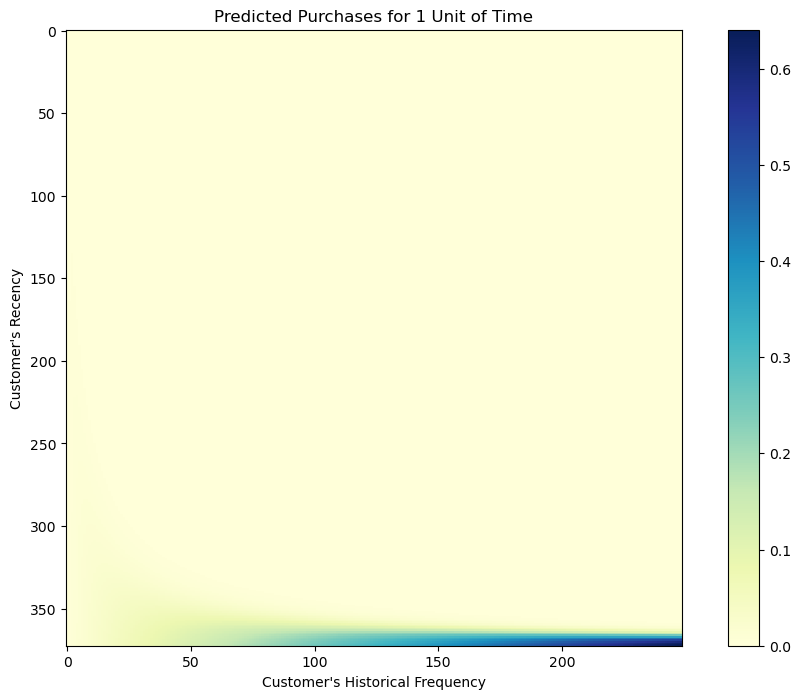

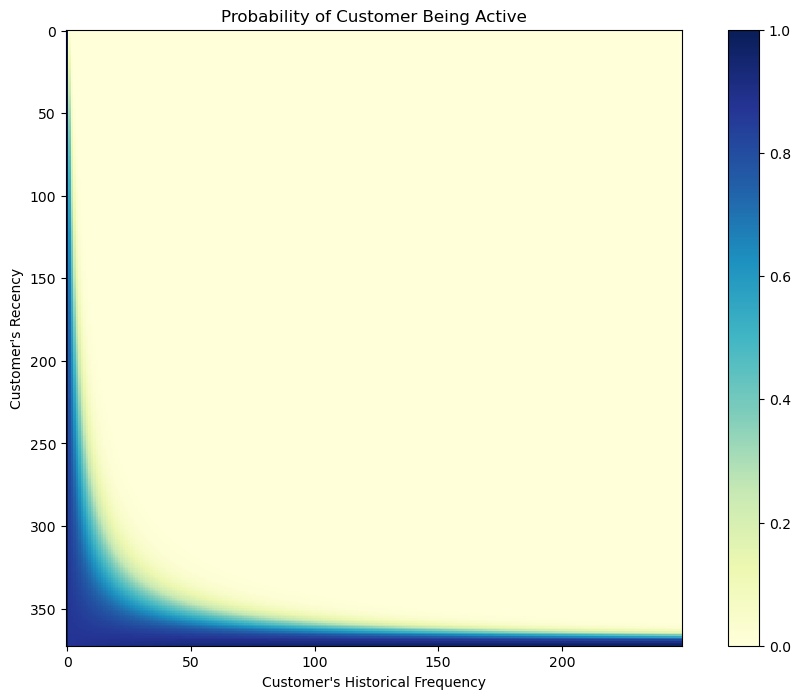

In [11]:
# Plot model diagnostics
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix

# Visualize the model
plt.figure(figsize=(12, 8))
plot_frequency_recency_matrix(bgf, cmap='YlGnBu')
plt.title('Predicted Purchases for 1 Unit of Time')
plt.savefig('frequency_recency_matrix.png')

plt.figure(figsize=(12, 8))
plot_probability_alive_matrix(bgf, cmap='YlGnBu')
plt.title('Probability of Customer Being Active')
plt.savefig('probability_alive_matrix.png')

In [12]:
# Future purchases in 90 days for each customer
rfm['predicted_purchases_90d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    90,
    rfm['Frequency'],
    rfm['Recency'],
    rfm['T']
)

In [13]:
from lifetimes import GammaGammaFitter

# Only keep customers with positive monetary value
rfm_monetary = rfm[rfm['Monetary'] > 0]

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm_monetary['Frequency'], rfm_monetary['Monetary'])

# Predict average transaction value
rfm_monetary['predicted_monetary'] = ggf.conditional_expected_average_profit(
    rfm_monetary['Frequency'],
    rfm_monetary['Monetary']
)

In [14]:
# Create the holdout set (only for validation)
cutoff_date = '2011-09-01'
holdout_df = datatrend[datatrend['InvoiceDate'] >= cutoff_date]

# Compute actual 90-day spend per customer from holdout
actual_spend = holdout_df.groupby('CustomerID').apply(
    lambda x: (x['Quantity'] * x['UnitPrice']).sum()
).reset_index(name='actual_spend_90d')

C:\Users\DELL\AppData\Local\Temp\ipykernel_17768\3831055712.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_spend = holdout_df.groupby('CustomerID').apply(


In [15]:
# Predicted 90-day CLV
rfm_monetary['predicted_clv_90d'] = rfm_monetary['predicted_purchases_90d'] * rfm_monetary['predicted_monetary']

In [16]:

# Merge with predicted CLV
clv_eval = rfm_monetary.merge(actual_spend, on='CustomerID', how='inner')

KeyError: 'CustomerID'